<a href="https://colab.research.google.com/github/davidredmond21/101/blob/master/Edge_State_Hamiltonian_Softmax_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Feb 28 19:43:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone git@github.com:equal1/vshape-gate-optimizers.git


Cloning into 'vshape-gate-optimizers'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [5]:
from google.colab import files

uploaded = files.upload()

Saving utilities.py to utilities.py
Saving requirements.txt to requirements.txt
Saving interaction_Hamiltonian.py to interaction_Hamiltonian.py
Saving gate_optimizer.py to gate_optimizer.py
Saving QNN_density_matrix_formalism.py to QNN_density_matrix_formalism.py


In [6]:
from interaction_Hamiltonian import*
from QNN_density_matrix_formalism import*

import scipy.linalg as la
import seaborn as sn
import pandas as pd
from ipywidgets import *
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Data Generation

In [7]:
# Row-Major Tensor Indexing
def param_index(i,param_ranges):
    lens = [len(np.arange(*r)) for r in param_ranges]
    lens_prod = (*np.cumprod(lens[1:][::-1])[::-1],1)

    index = []
    for p in lens_prod:
        index.append(i // p)
        i = i % p
    return index

In [9]:
import ctypes
import multiprocessing as mp
manager = mp.Manager()

class HamiltonianDataset(Dataset):
    def __init__(self, voltage_ranges=[(0.1,5,.1)]*6, 
                 num_of_sites = 6, num_of_states_each_site = 2):
        self.num_of_sites = num_of_sites
        self.num_of_states_each_site = num_of_states_each_site
        self.ranges = [*voltage_ranges]
        self.aranges = np.array([np.arange(*r) for r in self.ranges])

        # Setup Interaction Hamiltonian
        self.Hint = InteractionHamiltonian(num_of_sites, num_of_states_each_site)
        self.state_names = tuple(self.Hint.return_interaction_terms()[1])
        self.delta_terms = list(self.Hint.return_interaction_terms()[0])
        
        # Define Edge States
        matching = [s for s in self.state_names if "a0" in s]
        matching = [s for s in matching if "c1" in s]
        matching = [s for s in matching if "d0" in s]
        self.matching = [s for s in matching if "f1" in s]
        self.indices = []
        for m in self.matching:
          self.indices.append(self.state_names.index(m))
  
        # Handle caching and repeated access
        self.cache = manager.dict()
          
    
    def generate_hamiltonian(self, j_terms):
        gamma_terms = [0 for iter in range(self.num_of_sites)] # we assume no decoherence
        t_max = 0
        steps = 1000
        index = 1
        choice = 'Hamiltonian' # Only Option

        QNN = QnnDensityMatrixFormalism(num_of_sites=self.num_of_sites, 
                  num_of_states_each_site=self.num_of_states_each_site,
                  j_terms=j_terms, gamma_terms=gamma_terms, 
                  delta_terms=self.delta_terms,t_min=0, t_max=t_max,
                  steps=steps, init_condition_index=index, choice = choice)
        c_matrix = np.zeros((self.num_of_states_each_site ** self.num_of_sites,
                            self.num_of_states_each_site ** self.num_of_sites))
        Hamiltonian_matrix = QNN.create_ODE_or_Hamiltonian_matrix(0, c_matrix)
        eigvals, eigvecs = la.eig(Hamiltonian_matrix)
        min_vec = np.argmin(eigvals)
        probs = np.abs(np.square(eigvecs[:,min_vec]))
        return probs

    def __getitem__(self, index):
        param_idx = param_index(index, self.ranges)
        params = [self.aranges[r][idx] for r, idx in enumerate(param_idx)]

        if index not in self.cache:
            self.cache[index] = self.generate_hamiltonian(params)[self.indices]

        #params = params / np.array([r[1] for r in self.ranges])
        return torch.tensor(params, dtype=torch.float32)[:], torch.from_numpy(self.cache[index].astype(np.float32))[:]

    def __len__(self):
        return np.prod([len(a) for a in self.aranges])

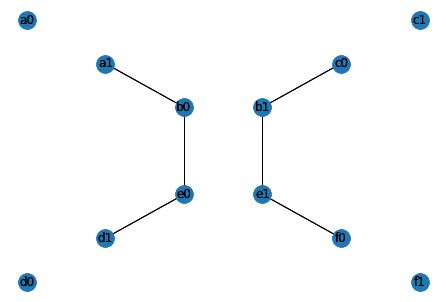

In [10]:
dataset = HamiltonianDataset() 

In [11]:
dataset_size = len(dataset)
subset_size = 50000
random.seed(42)
indices = random.sample(range(dataset_size), subset_size)
val_ratio = .2
train_indices, val_indices = indices[:int(subset_size*(1-val_ratio))], indices[int(subset_size*(1-val_ratio)):]

train_ds = torch.utils.data.Subset(dataset, train_indices)
val_ds = torch.utils.data.Subset(dataset, val_indices)

batch_size = 512
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"Training samples: {len(train_ds)}, Validation Samples:{len(val_ds)}")

Training samples: 40000, Validation Samples:10000


In [26]:
model = nn.Sequential(nn.Linear(6, 64), 
                      nn.ReLU(),
                      nn.Linear(64, 128),
                      nn.ReLU(),
                      # nn.Linear(128, 128),
                      # nn.ReLU(),
                      # nn.Linear(128, 128),
                      # nn.ReLU(),
                      # nn.Linear(128, 128),
                      # nn.ReLU(),
                      # nn.Linear(128, 128),
                      # nn.ReLU(),
                      nn.Linear(128, 32),
                      nn.Tanh(),
                      nn.Linear(32, 4))

In [20]:
# def ce_loss(input, target, size_average=None, reduce=None, reduction='mean'):
#     # type: (Tensor, Tensor, Optional[bool], Optional[bool], str) -> Tensor
#     if not torch.jit.is_scripting():
#         tens_ops = (input, target)
#         if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
#             return handle_torch_function(
#                 l1_loss, tens_ops, input, target, size_average=size_average, reduce=reduce,
#                 reduction=reduction)
#     if not (target.size() == input.size()):
#         warnings.warn("Using a target size ({}) that is different to the input size ({}). "
#                       "This will likely lead to incorrect results due to broadcasting. "
#                       "Please ensure they have the same size.".format(target.size(), input.size()),
#                       stacklevel=2)
#     if size_average is not None or reduce is not None:
#         reduction = _Reduction.legacy_get_string(size_average, reduce)
#     if target.requires_grad:
#         ret = torch.abs(input - target)
#         if reduction != 'none':
#             ret = torch.mean(ret) if reduction == 'mean' else torch.sum(ret)
#     else:
#         expanded_input, expanded_target = torch.broadcast_tensors(input, target)
#         ret = torch._C._nn.l1_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))
#     return ret

In [27]:
from torch import optim
criterion = nn.L1Loss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
opt = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=4, bias=True)
)

In [28]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, targets in train_dl:
        steps += 1
        inputs, targets = inputs.to(device), targets.to(device)
        opt.zero_grad()
        pred = model.forward(inputs)
        loss = criterion(pred, targets)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, targets in val_dl:
                    inputs, targets = inputs.to(device), targets.to(device)
                    pred = model.forward(inputs)
                    batch_loss = criterion(pred, targets)
                    test_loss += batch_loss.item()

            train_losses.append(running_loss/len(train_dl))
            test_losses.append(test_loss/len(val_dl))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.9f}.. "
                  f"Test loss: {test_loss/len(val_dl):.9f}.. ")
            running_loss = 0
            model.train()

Epoch 1/20.. Train loss: 0.039674450.. Test loss: 0.023872017.. 
Epoch 1/20.. Train loss: 0.021404254.. Test loss: 0.016584720.. 
Epoch 1/20.. Train loss: 0.014945138.. Test loss: 0.012761502.. 
Epoch 1/20.. Train loss: 0.011971826.. Test loss: 0.010476752.. 
Epoch 1/20.. Train loss: 0.009737992.. Test loss: 0.009410613.. 
Epoch 1/20.. Train loss: 0.008781709.. Test loss: 0.007838604.. 
Epoch 1/20.. Train loss: 0.007256736.. Test loss: 0.009549756.. 
Epoch 2/20.. Train loss: 0.008159196.. Test loss: 0.006742503.. 
Epoch 2/20.. Train loss: 0.007110561.. Test loss: 0.006911393.. 
Epoch 2/20.. Train loss: 0.006976211.. Test loss: 0.007632304.. 
Epoch 2/20.. Train loss: 0.006985245.. Test loss: 0.006903024.. 
Epoch 2/20.. Train loss: 0.006381439.. Test loss: 0.005076458.. 
Epoch 2/20.. Train loss: 0.006572746.. Test loss: 0.006250654.. 
Epoch 2/20.. Train loss: 0.004941105.. Test loss: 0.004844687.. 
Epoch 2/20.. Train loss: 0.004601794.. Test loss: 0.004362348.. 
Epoch 3/20.. Train loss: 

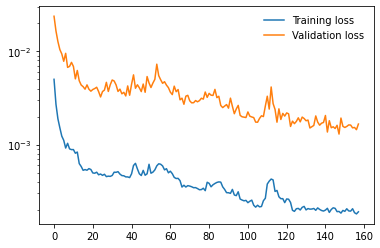

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

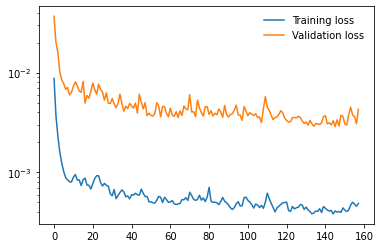

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

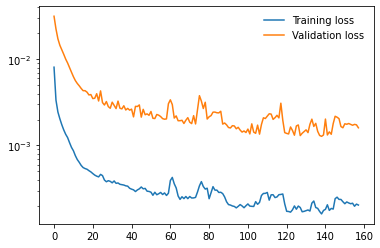

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

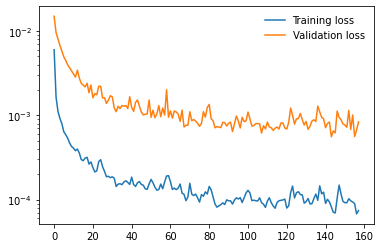

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

In [24]:
mse = nn.MSELoss()
mae = nn.L1Loss()

In [25]:
test_mse = 0
test_mae = 0
test_mag = 0
edge_mae = 0

model.eval()
with torch.no_grad():
    for inputs, targets in val_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        pred = model.forward(inputs)
        test_mse += mse(pred,targets).item()
        test_mae += mae(pred,targets).item()
        test_mag += torch.mean(torch.abs(targets))
        # edge_mae += mae(pred[:, :])
print(f"Test MSE: {test_mse/len(val_dl)}.. ")
print(f"Test MAE: {test_mae/len(val_dl)}.. ")
print(f"Test MAG: {test_mag/len(val_dl)}.. ")
print(f"Test PMSE: {100*test_mse/test_mag}.. ")
print(f"Test PMAE: {100*test_mae/test_mag}.. ")


Test MSE: 3.528822344378568e-05.. 
Test MAE: 0.004306484409607947.. 
Test MAG: 0.029639532789587975.. 
Test PMSE: 0.11905795335769653.. 
Test PMAE: 14.52952766418457.. 


tensor([[1.4000, 2.5000, 2.9000, 4.8000, 1.3000, 3.6000]], device='cuda:0')


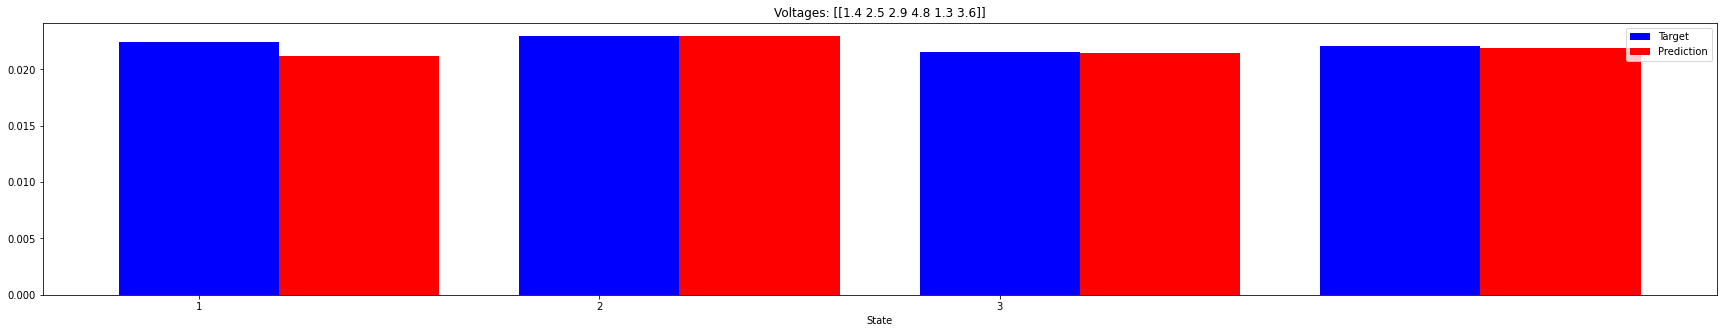

In [18]:
model.eval()
inputs, targets = val_ds[1000]
with torch.no_grad():
    inputs, targets = inputs.to(device)[None, :], targets.to(device)[None, :]
    print(inputs)

    pred = model.forward(inputs)
    pred = pred.cpu().numpy()
    targets = targets.cpu().numpy()
    indices = range(4)
    plt.figure(figsize=(30,5))
    width = np.min(np.diff(indices))/2.5
    plt.bar(indices-width,targets[0],width,color='b', label="Target")
    plt.bar(indices,pred[0],width,color='r', label="Prediction")
    plt.title(f"Voltages: {inputs.cpu().numpy()[:6]}")
    plt.legend()
    plt.xlabel("State")
    plt.xticks(np.arange(-width,3-width), range(1,65))


In [19]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
torch.save({
            'epoch': 30,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': test_mae
            }, "hamiltonian_softmax_bs512_50000")

In [ ]:
!mv hamiltonian_softmax_bs512_50000 /gdrive/Shared\ drives/*/Quantum\ Modelling/Models/

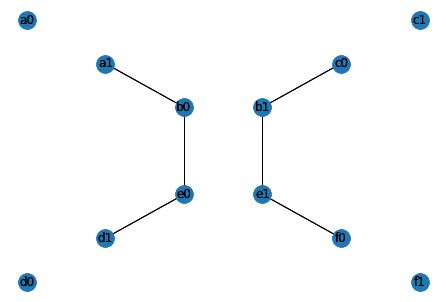

In [ ]:
vai_dataset = HamiltonianDataset(voltage_ranges=[(1.5,1.55,1)]*5+[(.5,5.0)])

In [ ]:
len(vec_dataset)

32

In [ ]:
model.eval()
preds, targets = np.zeros((32,64)),np.zeros((32,64))
model.eval()
with torch.no_grad():
    for i in range(len(vec_dataset)):
        inputs, target = vec_dataset[i]
        inputs, target = inputs.to(device), target.to(device)
        pred = model.forward(inputs).cpu().numpy()
        preds[i] = pred[0]
        targets[i] = target.cpu().numpy()[0]


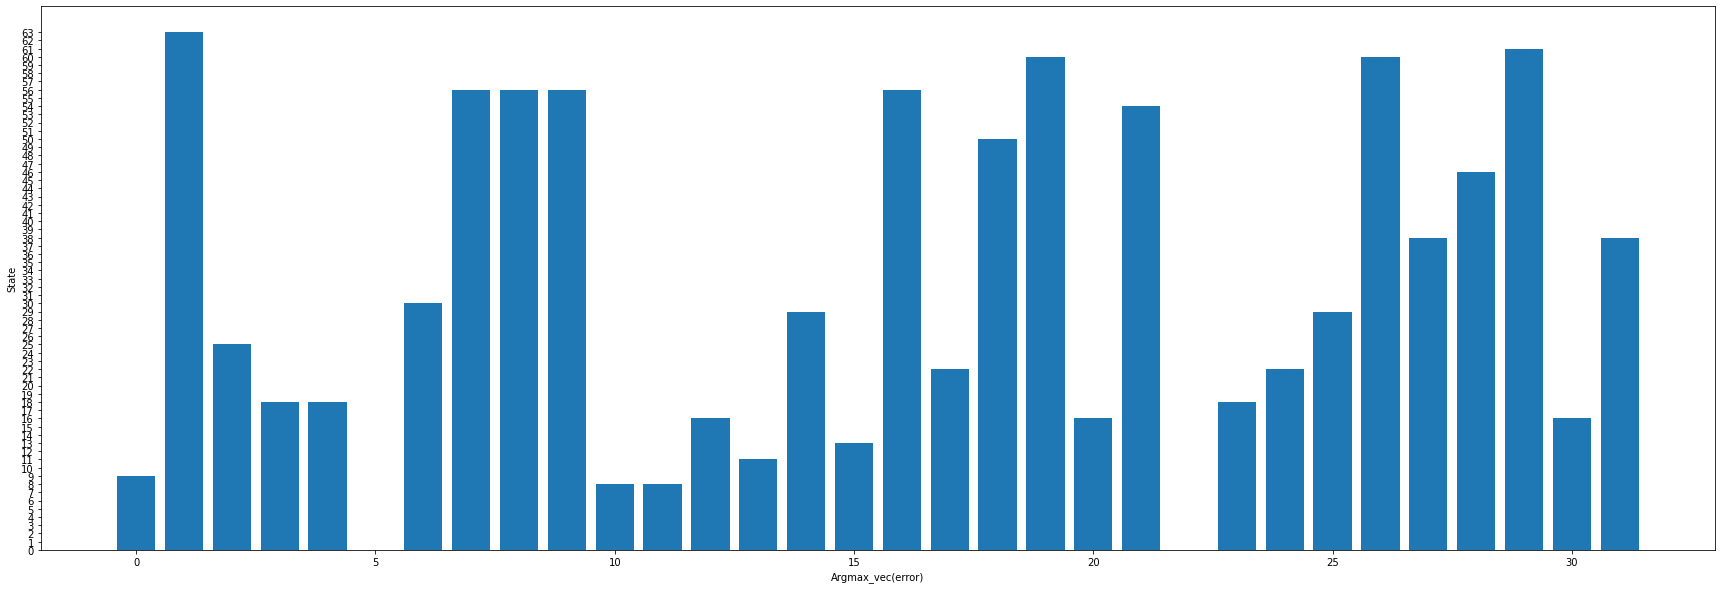

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(range(32),np.argmax(np.abs(preds-targets), axis=1))
plt.xlabel("Argmax_vec(error)")
plt.ylabel("State")
plt.yticks(range(64))
plt.show()

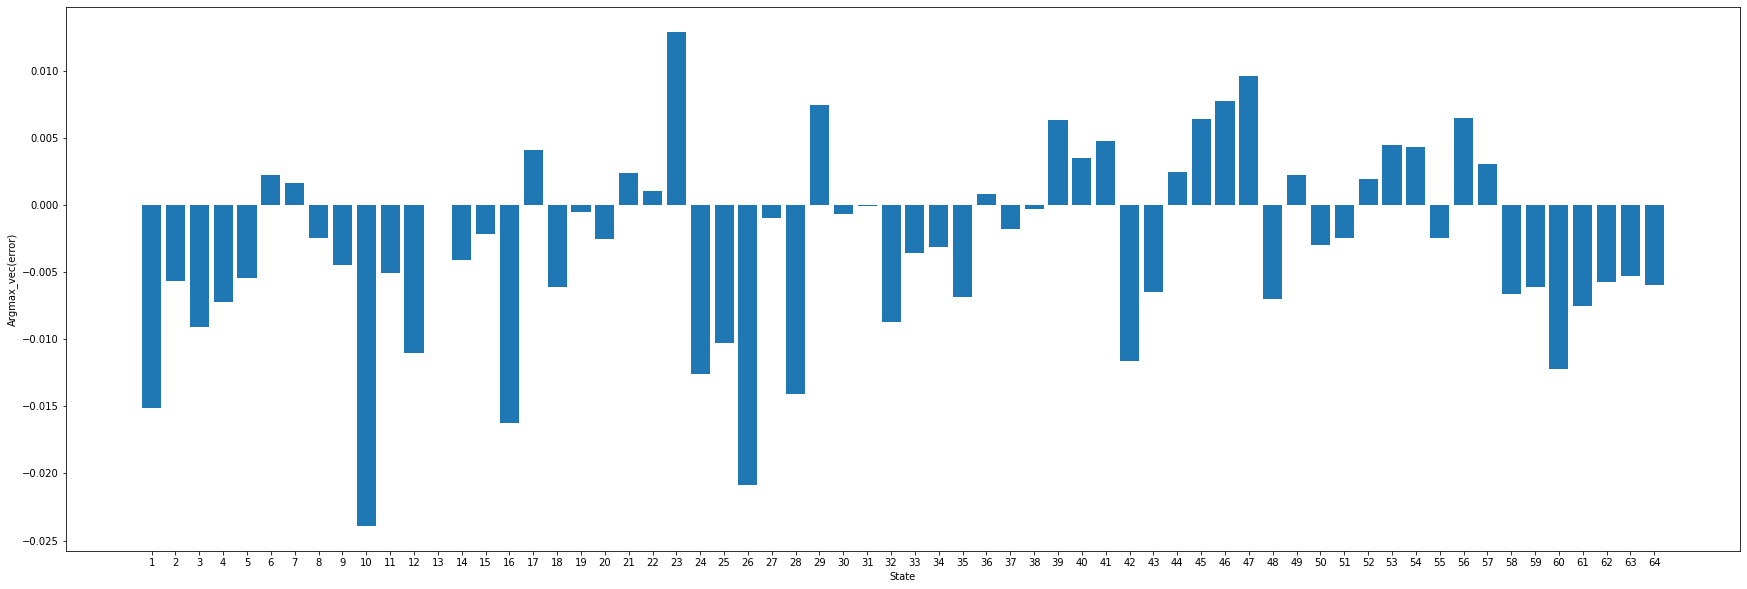

In [ ]:
plt.figure(figsize=(30,10))
plt.bar(range(64),(preds-targets)[0,:])
plt.xticks(range(64), range(1,65))
plt.xlabel("State")
plt.ylabel("Argmax_vec(error)")
plt.show()

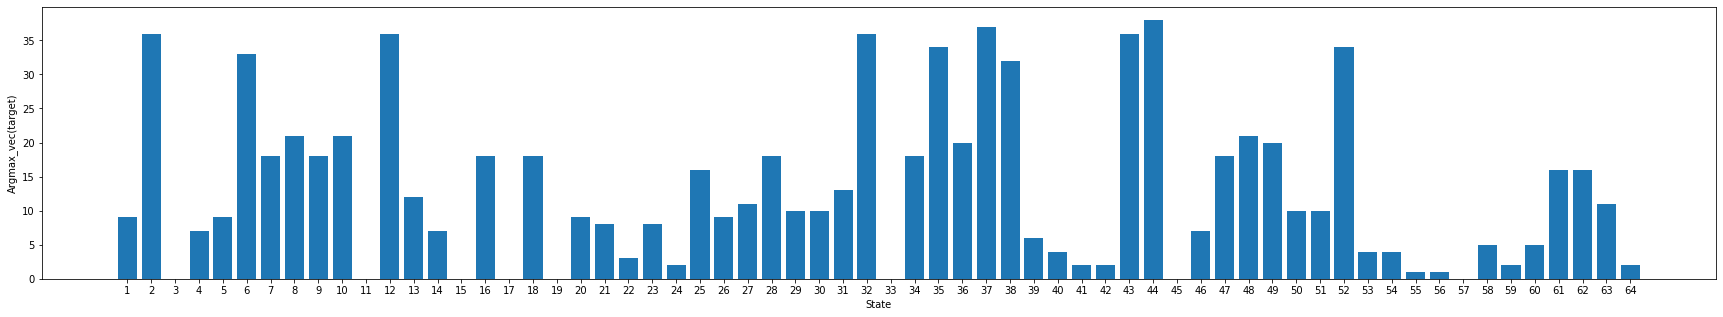

In [ ]:
plt.figure(figsize=(30,5))
plt.bar(range(64),np.argmax(targets, axis=1))
plt.xticks(range(64), range(1,65))
plt.xlabel("State")
plt.ylabel("Argmax_vec(target)")
plt.show()

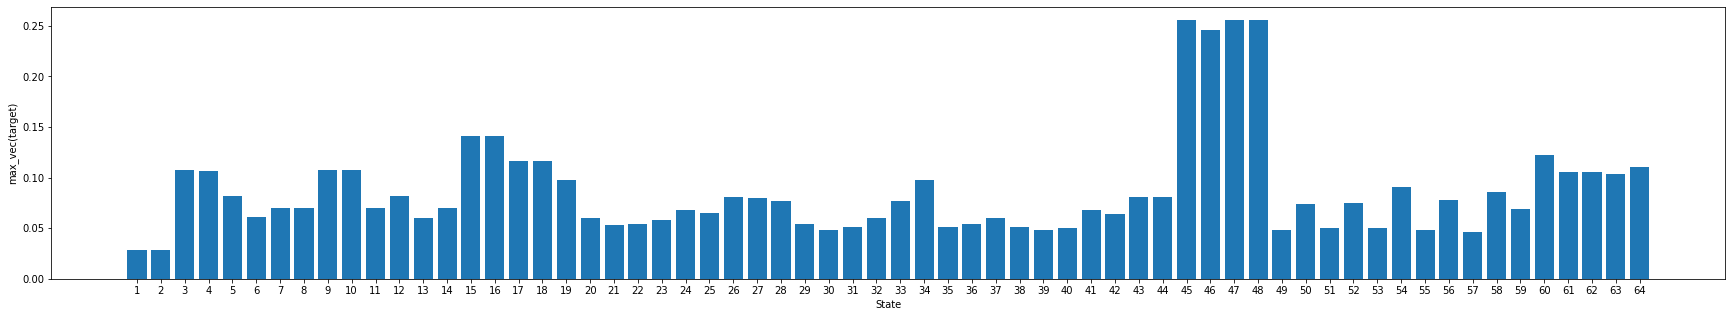

In [ ]:
plt.figure(figsize=(30,5))
plt.bar(range(64),np.max(targets, axis=1))
plt.xticks(range(64), range(1,65))
plt.xlabel("State")
plt.ylabel("max_vec(target)")
plt.show()